# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

**Описание данных**  
**Признаки**  
DateCrawled — дата скачивания анкеты из базы  
VehicleType — тип автомобильного кузова  
RegistrationYear — год регистрации автомобиля  
Gearbox — тип коробки передач  
Power — мощность (л. с.)  
Model — модель автомобиля  
Kilometer — пробег (км)  
RegistrationMonth — месяц регистрации автомобиля  
FuelType — тип топлива  
Brand — марка автомобиля  
Repaired — была машина в ремонте или нет   
DateCreated — дата создания анкеты  
NumberOfPictures — количество фотографий автомобиля  
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  
**Целевой признак**  
Price — цена (евро)  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import re
import time

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV 

from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

In [2]:
# константы
RANDOM_STATE = 12345

In [3]:
# снимем ограничения, чтобы видеть информацию полностью
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
try:
    autos_data = pd.read_csv('/datasets/autos.csv')
except:
    autos_data = pd.read_csv('C:\\Users\\Константин\\Desktop\\Файлы\\Модуль 3\\Численные методы\\autos.csv')

In [5]:
# функция для вывода основной информации о данных
def data_research1(data):
    display(data.head())
    print()
    data.info()
    print()
    print('Пропуски:', data.isna().sum().sum(), 'это {:.2%} от всех данных.'
          .format(data.isna().sum().sum() / (data.shape[0] * data.shape[1])))
    print()
    print('Процент (%) пропусков в каждой категории данных.')
    display((data.isna().sum() / data.shape[0]) * 100)
    print()
    print('Явные дубликаты:', data.duplicated().sum(), 'это {:.2%} от всех данных.'
          .format(data.duplicated().sum() / data.shape[0]))
    
    # строим график распределения 
    data.hist(bins=100,figsize=(15, 20))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
Repaired             20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64


Явные дубликаты: 4 это 0.00% от всех данных.


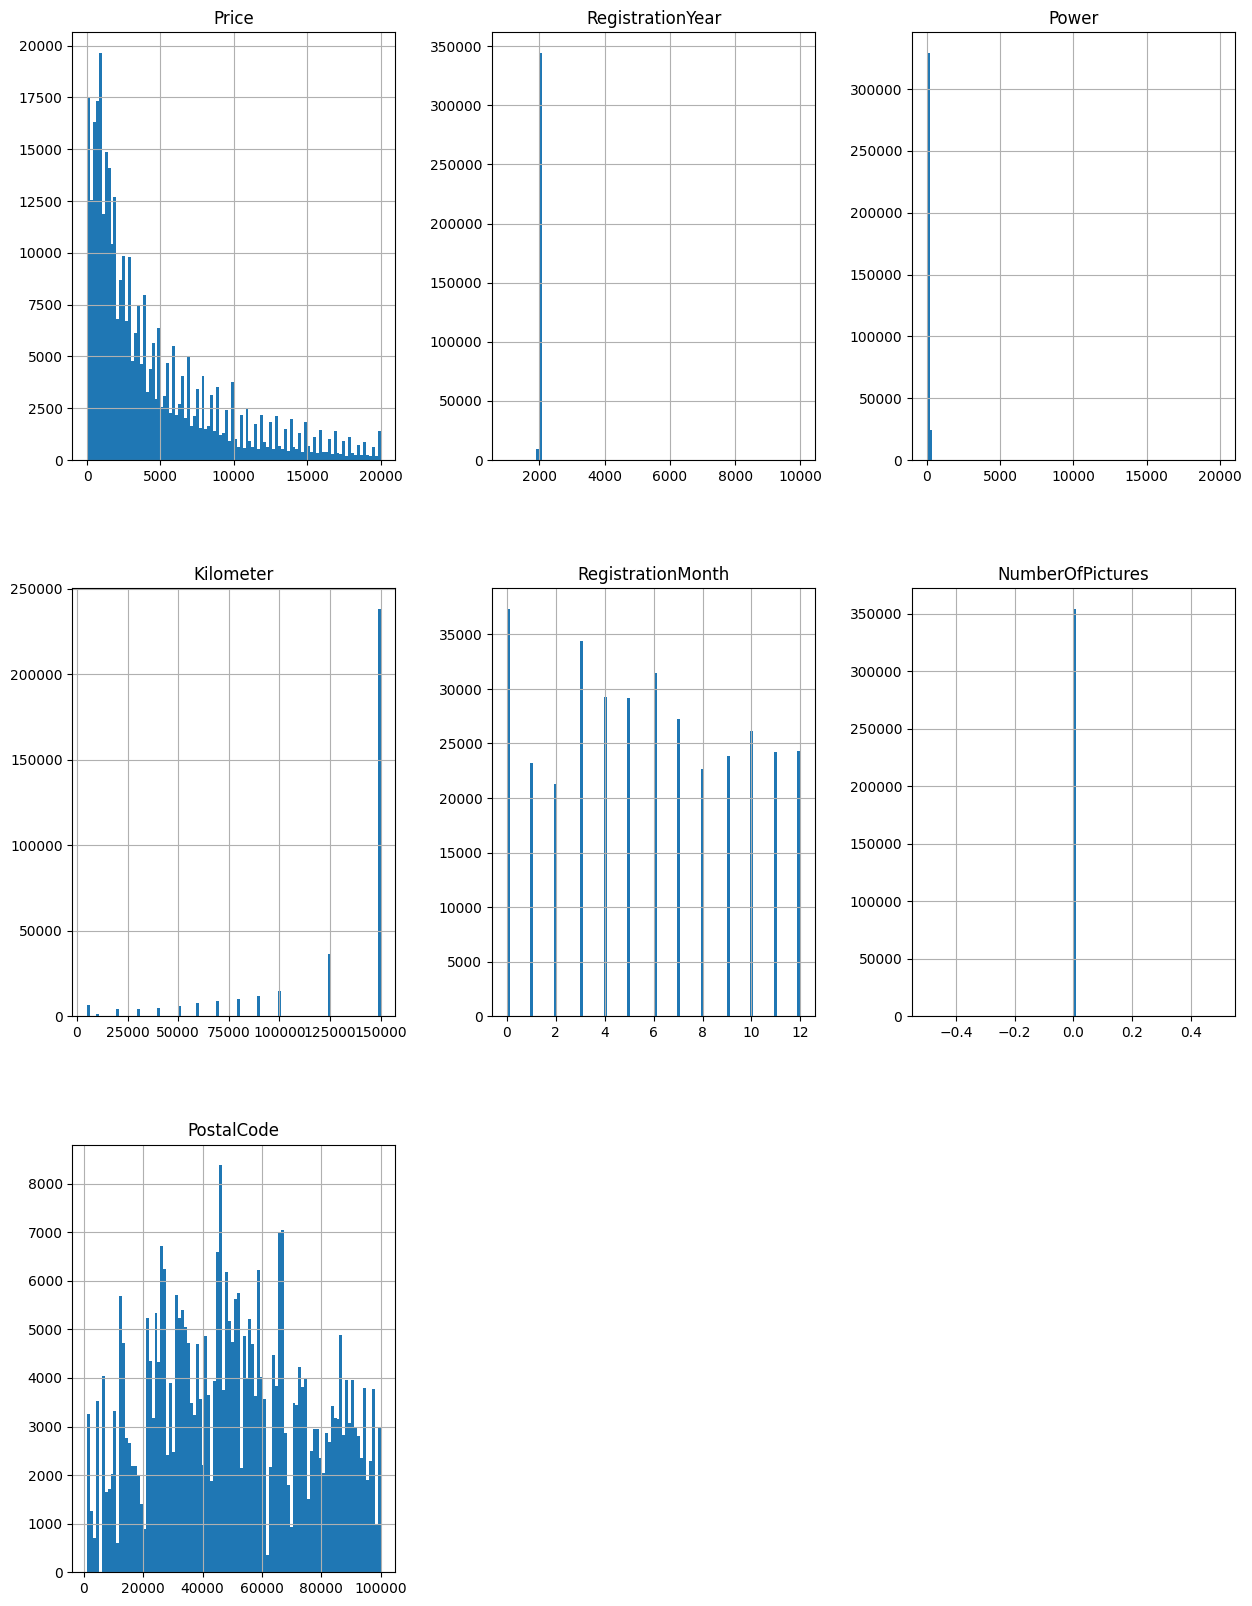

In [6]:
data_research1(autos_data)

**В данных присутствуют:**
- Не корректный регистр в названиях. Присутствуют прописные буквы.
- Пропуски. 3.19% от всех данных.
- Явные дубликаты. 
- Редкие и выбивающиеся значения. Пример: год более нынешнего.

Подготовим данные.

In [7]:
# функция для преобразования строки из верблюжьего регистра в змеиный
def registre1(data):
    for c in data.columns:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        s2 = re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()
        data.rename(columns={c:s2}, inplace = True)

In [8]:
registre1(autos_data)

In [9]:
autos_data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Определим какие признаки понадобятся для прогнозирования.

Выявим признаки которые можно удалить, чтобы облегчить работу алгоритма обучения.  
**Признаки**   
DateCrawled — дата скачивания анкеты из базы. Эта информация не известна клиенту. Удалим.    
VehicleType — тип автомобильного кузова. У каждого клиента свои предпочтения и задачи. Оставим.    
RegistrationYear — год регистрации автомобиля. Информация по которой можно определить износ. Оставим.    
Gearbox — тип коробки передач. У каждого клиента свои предпочтения и задачи. Оставим.   
Power — мощность (л. с.). У каждого клиента свои предпочтения и задачи. Оставим.   
Model — модель автомобиля. У каждого клиента свои предпочтения и задачи. Оставим.  
Kilometer — пробег (км). Информация по которой можно определить износ. Оставим.   
RegistrationMonth — месяц регистрации автомобиля. В зависимости от месяца в одном и том же году разница в эксплуатации может составить 12 месяцев. Информация по которой можно определить износ. Оставим.   
FuelType — тип топлива. У каждого клиента свои предпочтения и задачи. Оставим.   
Brand — марка автомобиля. У каждого клиента свои предпочтения и задачи. Оставим.   
Repaired — была машина в ремонте или нет. Информация по которой можно определить износ. Оставим.    
DateCreated — дата создания анкеты. Даная информация могла быть полезной, если бы мы знали дату продажи и могли бы судить долго или быстро продался автомобиль за указанную цену. Удалим.  
NumberOfPictures — количество фотографий автомобиля. Без осмотра сделка вряд ли стоится. Поэтому наличие фитографий не так важно, а их количество тем более. Удалим.   
PostalCode — почтовый индекс владельца анкеты (пользователя). Это информация о месте, где продается автомобиль. От этого может зависеть цена, если бы место было более обобщенным район, город. Почтовый индекс будет только нагружать алгоритм. Удалим.    
LastSeen — дата последней активности пользователя. Эта информация не дает понятия о состоянии автомобиля. Она случайна, зависит от активности пользователя и количества обращений. Удалим.  

Сперва удалим столбцы со случайной информацией и добавленной при формировании базы данных,  для того что бы точнее определить дубликаты.

In [10]:
# удаление столбцов
autos_data2 = autos_data.copy(deep=True).drop(['date_crawled', 'number_of_pictures', 'last_seen'], axis=1)

In [11]:
print('Явные дубликаты:', autos_data2.duplicated().sum(), 'это {:.2%} от всех данных.'
          .format(autos_data2.duplicated().sum() / autos_data2.shape[0]))

Явные дубликаты: 10194 это 2.88% от всех данных.


Удалим дубликаты.

In [12]:
a = autos_data2.shape[0]
autos_data2 = autos_data2.drop_duplicates()
print('Было удалено {:.2%} дубликатов.'.format(((a - autos_data2.shape[0]) / a)))

Было удалено 2.88% дубликатов.


Завершим удаление лишних признаков.

In [13]:
# удаление столбцов
autos_data2 = autos_data2.drop(['date_created', 'postal_code'], axis=1)

In [14]:
autos_data2.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


Посчитаем сколько пропусков в отредактированной таблице.

In [15]:
print('Пропуски:', autos_data2.isna().sum().sum(), 'это {:.2%} от всех данных.'
          .format(autos_data2.isna().sum().sum() / (autos_data2.shape[0] * autos_data2.shape[1])))

Пропуски: 178196 это 4.71% от всех данных.


Пропусков менее 10% это не сильно повлияет на предсказания. Не будем пытаться их чем-то заменить, это может негативно повлиять на предсказания, а проверять так это или нет займет время.

In [16]:
# замена пропусков на значение 'не определено'
autos_data2 = autos_data2.fillna(value='undefined')

Обработаем аномалии.

In [17]:
autos_data2.describe()

,price,registration_year,power,kilometer,registration_month
count,344175.000000,344175.000000,344175.000000,344175.000000,344175.000000
mean,4395.893249,2004.223578,109.904886,128256.744389,5.704525
std,4506.888598,90.906705,191.468515,37907.597348,3.729554
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1000.000000,1999.000000,68.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6300.000000,2008.000000,141.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


In [18]:
# функция вывода графика с усами для количественных параметров
def anomalies(data):
    for c in data.columns:
        col_type = data[c].dtype
        if col_type == 'int64':
            
            plt.figure(figsize=(20,5))            
            sns.boxplot(data[c])
            plt.title(c,fontsize=25)
            plt.show()
            

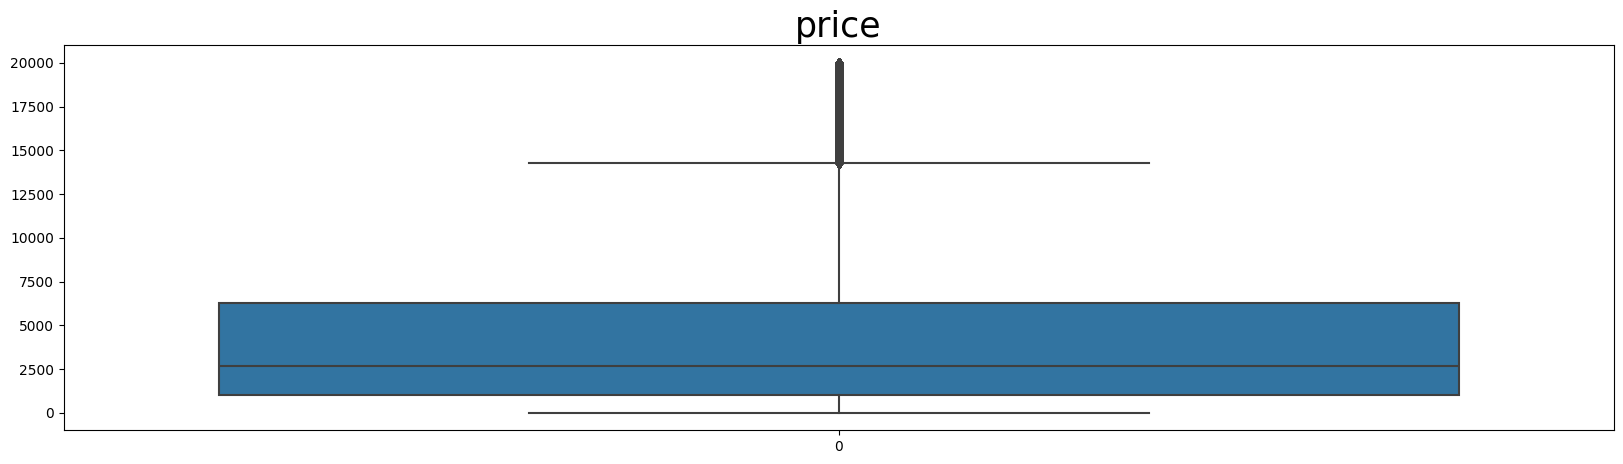

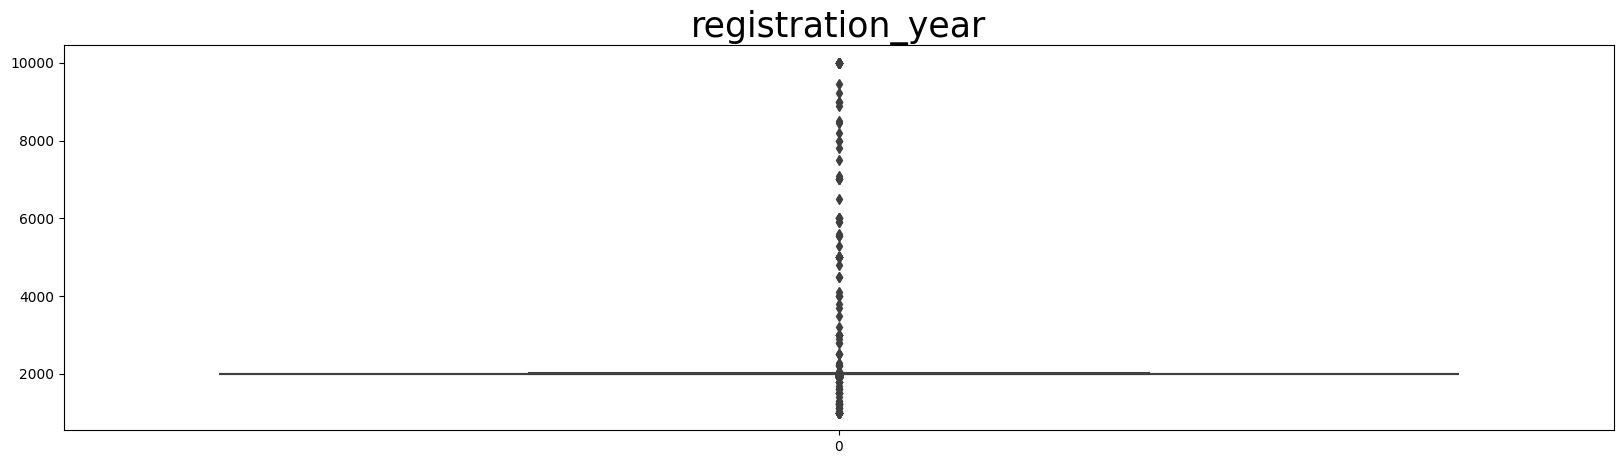

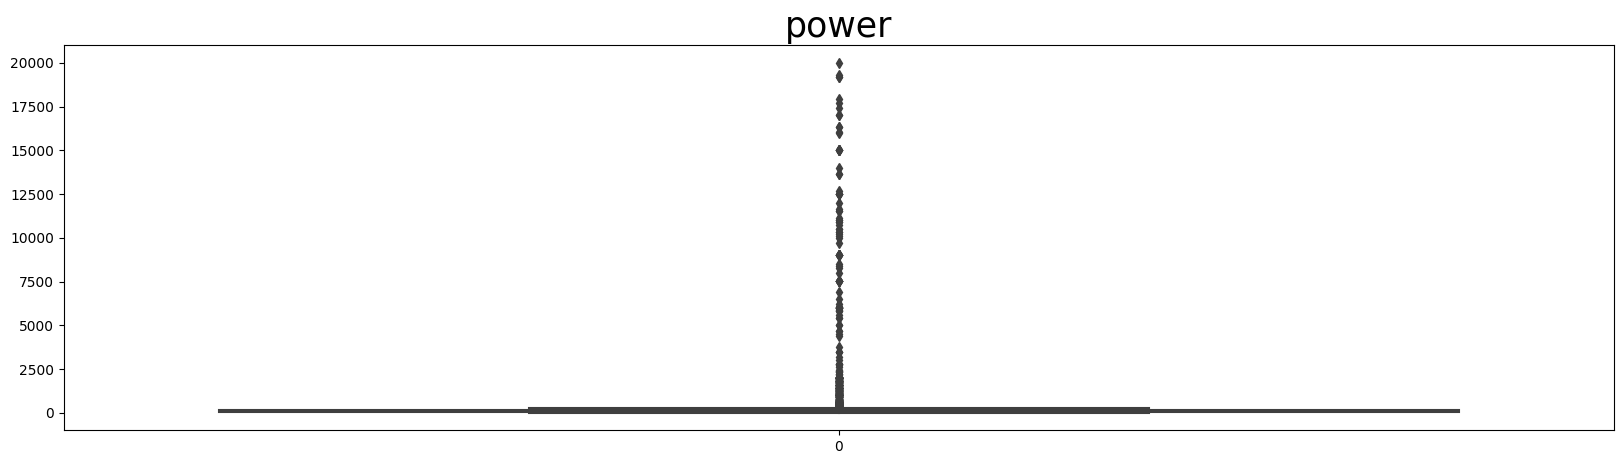

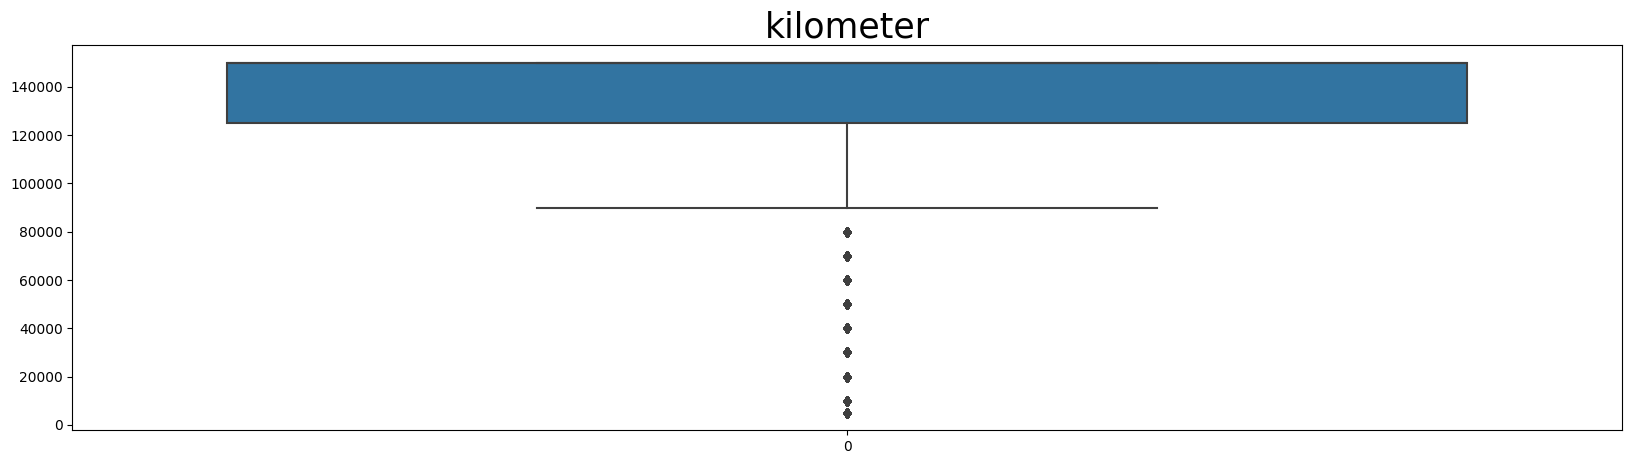

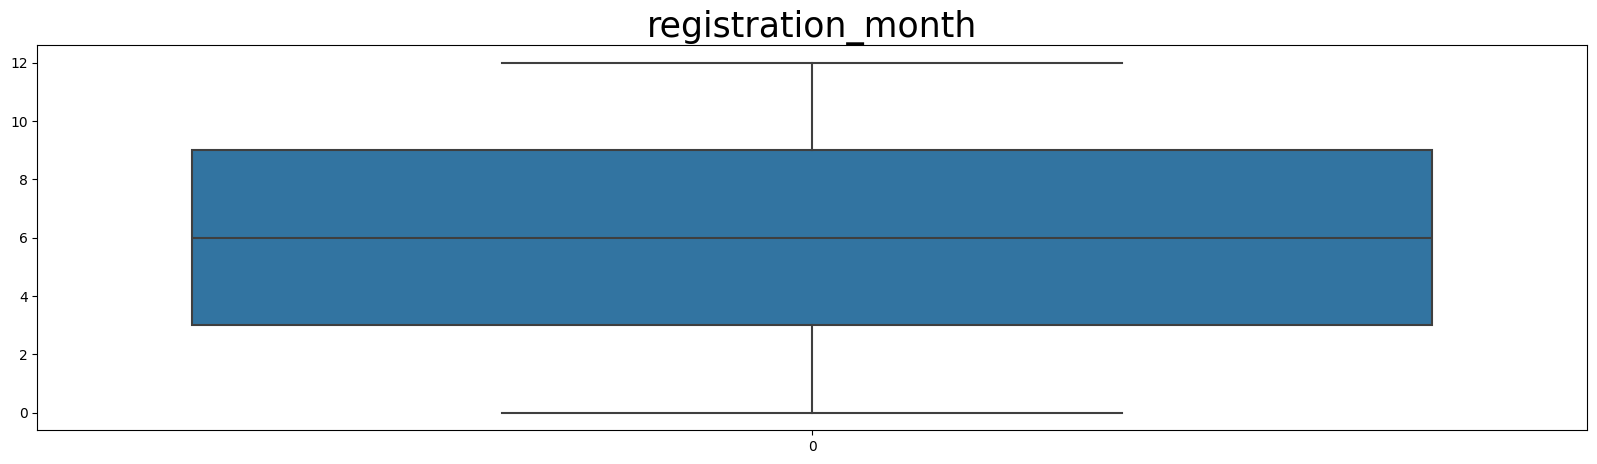

In [19]:
anomalies(autos_data2)

Ограниччим параметры на границах 

Параметры цена и пробег уберем значения меньше нуля, чтобы исключить варианты продаж из салона и где клиент хочет избавиться от автомобиля как от металлолома. В месяцах аномалий нет. Года ограничим нынешним. Мощность ограничим 1500 (л. с.) это предел для большинства спортивных автомобилей. 

In [20]:
# переменная для замера удаленных строк
a = autos_data2.shape[0]
# удаление аномальных значений
autos_data2 = autos_data2[autos_data2['price'] > 0]
autos_data2 = autos_data2[(autos_data2['registration_year'] > 1990) 
                            & (autos_data2['registration_year'] < 2016)]
autos_data2 = autos_data2[(autos_data2['power'] < 1500)]
autos_data2 = autos_data2[autos_data2['kilometer'] > 0]
print('Было удалено {:.2%} редких значений.'.format(((a - autos_data2.shape[0]) / a)))

Было удалено 12.86% редких значений.


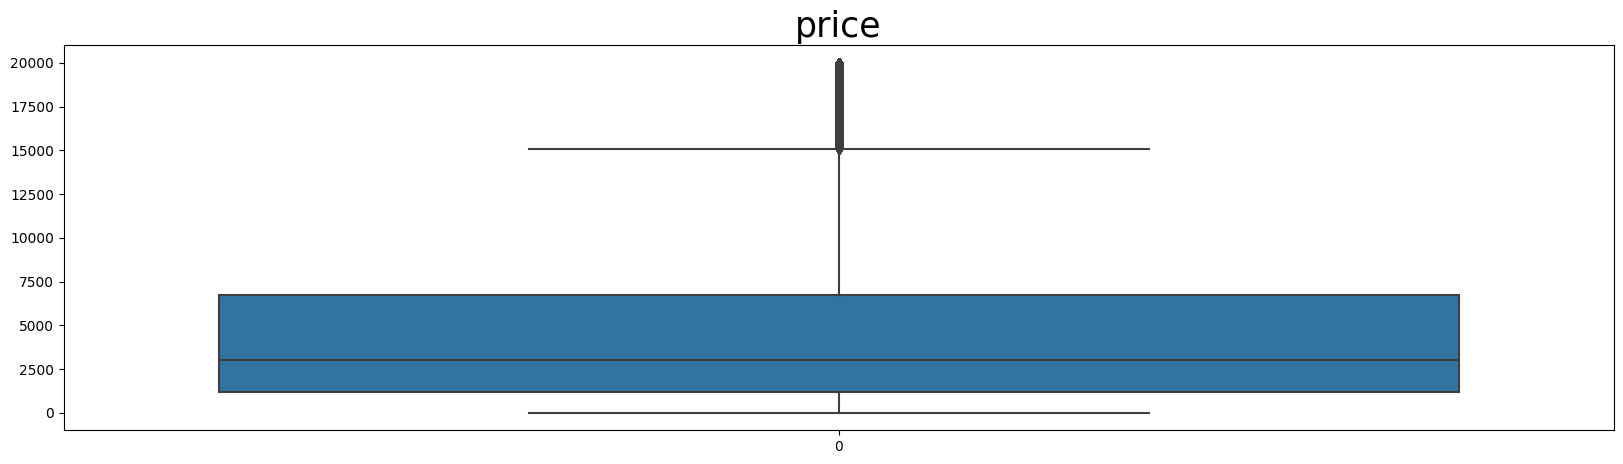

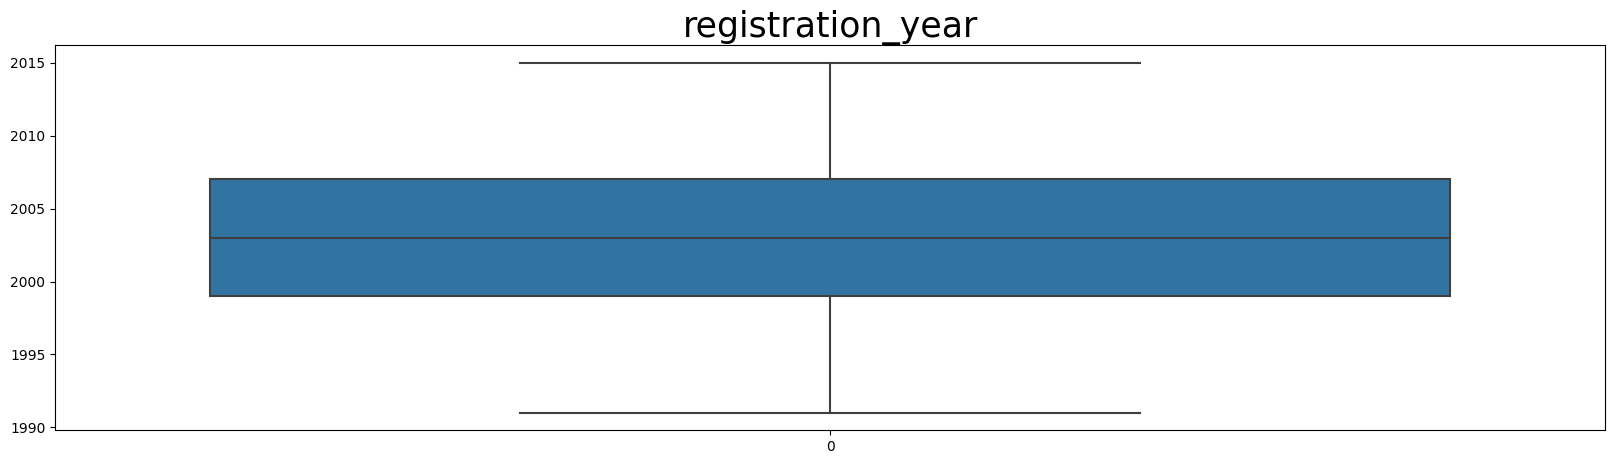

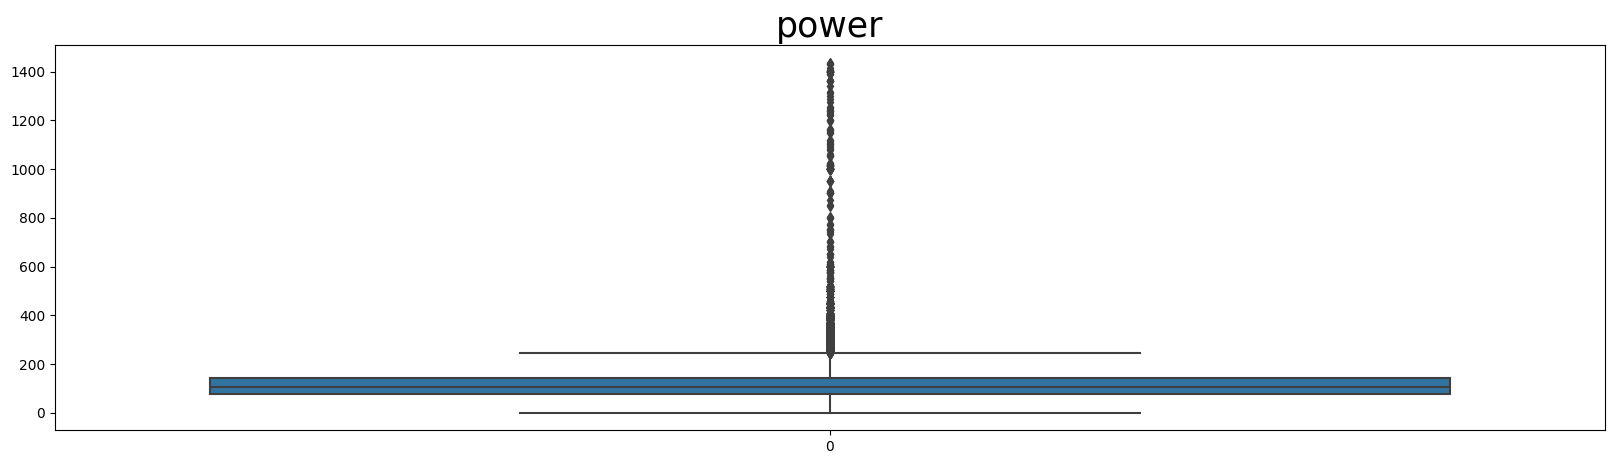

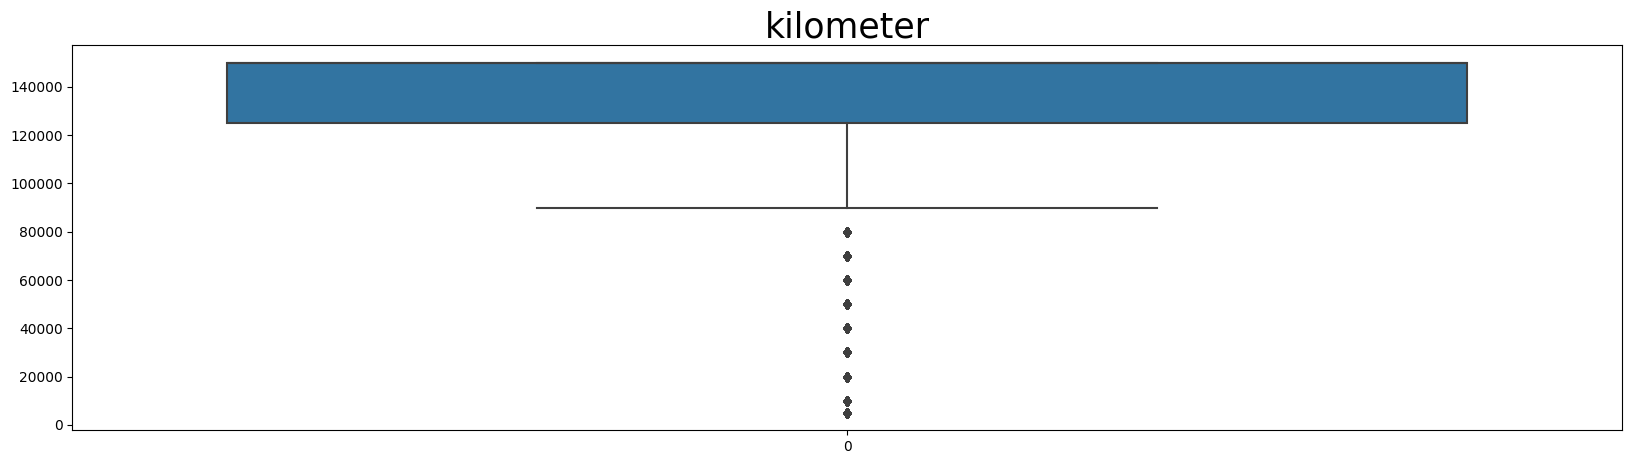

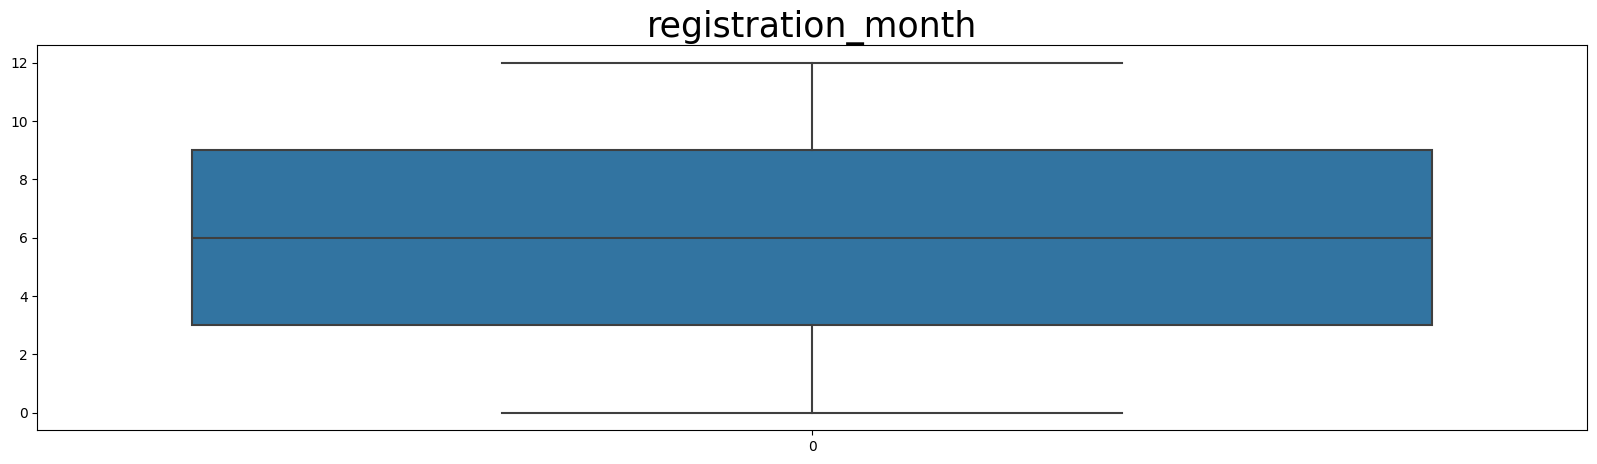

In [21]:
anomalies(autos_data2)

In [22]:
# функция для вывода уникальных категориальных значений 
def categories(data):
    for c in data.columns:
        col_type = data[c].dtype
        if col_type == 'object':
            print(data[c].value_counts())
            print('_______')
            

In [23]:
categories(autos_data2)

vehicle_type
sedan          82562
small          74332
wagon          61108
bus            26923
convertible    18095
coupe          13710
suv            10873
undefined       9636
other           2681
Name: count, dtype: int64
_______
gearbox
manual       229450
auto          57924
undefined     12546
Name: count, dtype: int64
_______
model
golf                  23687
other                 18713
3er                   17293
undefined             12553
polo                  11003
corsa                 10707
astra                  9381
a4                     9007
passat                 8956
c_klasse               7573
5er                    7032
e_klasse               5882
a3                     5287
focus                  5171
fiesta                 5053
a6                     5049
2_reihe                4356
twingo                 4201
fortwo                 3962
transporter            3869
vectra                 3675
a_klasse               3587
1er                    3230
mondeo      

Для упрощения работы и избежания ошибок алгоритма с закодированными данными например (OHE) уберем редко встречающееся модели автомобили , а именно меньше 100 упоминаний.

In [24]:
# функция удаления аномальных категориальных значений 
def removal(data):
    for i in data['model'].value_counts()[data['model'].value_counts() < 100].index:
            data.drop(data[(data['model'] == i ) ].index, inplace=True)

In [25]:
# переменная для замера удаленных строк
a = autos_data2.shape[0]
removal(autos_data2)
print('Было удалено {:.2%} редких значений.'.format(((a - autos_data2.shape[0]) / a)))

Было удалено 0.72% редких значений.


In [26]:
print('Было удалено {:.2%} от всех данных.'.format(((autos_data.shape[0] - autos_data2.shape[0]) / autos_data.shape[0])))

Было удалено 15.98% от всех данных.


Пропуски были заполнены на значения 'не определено'. В результате удаления дубликатов и аномалий было потеряно менее 10% данных, что считаю приемлемым. Приступаю к подготовке данных для обучения в алгоритмах.

Зкодирую категориальные и стандартизирую количественны параметры для работы с алгоритмами обучения и увеличения точности предсказаний.

In [27]:
# функцию разделения данных на обучающую, валидационную, тестовую выборки и кодирования в них данных методом category
def division_с(data):

    # создаем списки с количественными и категориальными признаками
    numeric = []
    category = []

            
    # преобразуем категориальные признаки (object) в (category)
    for i in data.columns:
        column1 = data[i].dtype
        if column1 == 'object':
            category.append(i)
            data[category] = data[category].astype('category')
            
    features = data.drop('price', axis=1)
    target = data['price'] 
    
    # фильтруем признаки  
    for i in features.columns:
        column1 = features[i].dtype
        if column1 == 'int64':
            numeric.append(i)
    
    # разделяем выборки в пропорции 60 20 20
    features_train_c, features_valid_c, target_train_c, target_valid_c = train_test_split(features, target, 
                                                                                  test_size=0.4, 
                                                                                  random_state=RANDOM_STATE)
    
    features_valid_c, features_test_c, target_valid_c, target_test_c = train_test_split(
    features_valid_c, target_valid_c, test_size=0.5, random_state=RANDOM_STATE)
    

                        
    # масштабируем количественные признаки
    scaler = StandardScaler()
    scaler.fit(features_train_c[numeric])

    features_train_c[numeric] = scaler.transform(features_train_c[numeric])
    features_valid_c[numeric] = scaler.transform(features_valid_c[numeric])
    features_test_c[numeric] = scaler.transform(features_test_c[numeric])
    
    

    
    return features_train_c, features_valid_c, features_test_c, target_train_c, target_valid_c, target_test_c 

In [28]:
# функцию разделения данных на обучающую, валидационную, тестовую выборки и кодирования в них данных методом OrdinalEncoder
def division_oe(data):
    features = data.drop('price', axis=1)
    target = data['price']
    
    # разделяем выборки в пропорции 60 20 20
    features_train_oe, features_valid_oe, target_train_oe, target_valid_oe = train_test_split(features, target, 
                                                                                  test_size=0.4, 
                                                                                  random_state=RANDOM_STATE)
    
    features_valid_oe, features_test_oe, target_valid_oe, target_test_oe = train_test_split(
    features_valid_oe, target_valid_oe, test_size=0.5, random_state=RANDOM_STATE)
    
    # создаем списки с количественными и категориальными признаками
    numeric = []
    category = []
    # фильтруем признаки по категориям 
    for i in features.columns:
        column1 = features[i].dtype
        if column1 == 'int64':
            numeric.append(i)
            
        if column1 == 'object':
            category.append(i)
                        
    # масштабируем количественные признаки
    scaler = StandardScaler()
    scaler.fit(features_train_oe[numeric])

    features_train_oe[numeric] = scaler.transform(features_train_oe[numeric])
    features_valid_oe[numeric] = scaler.transform(features_valid_oe[numeric])
    features_test_oe[numeric] = scaler.transform(features_test_oe[numeric])
    
    # преобразовываем категориальные
    ordina = OrdinalEncoder()
    ordina.fit(features_train_oe[category])

    features_train_oe[category] = ordina.transform(features_train_oe[category])
    features_valid_oe[category] = ordina.transform(features_valid_oe[category])
    features_test_oe[category] = ordina.transform(features_test_oe[category])
    
    return features_train_oe, features_valid_oe, features_test_oe, target_train_oe, target_valid_oe, target_test_oe 

In [29]:
# функцию разделения данных на обучающую, валидационную, тестовую выборки и кодирования в них данных
def division_ohe(data):
    features = data.drop('price', axis=1)
    target = data['price']
    
    # разделяем выборки в пропорции 60 20 20
    features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features, target, 
                                                                                  test_size=0.4, 
                                                                                  random_state=RANDOM_STATE)
    
    features_valid_ohe, features_test_ohe, target_valid_ohe, target_test_ohe = train_test_split(
    features_valid_ohe, target_valid_ohe, test_size=0.5, random_state=RANDOM_STATE)
    
    # создаем списки с количественными и категориальными признаками
    numeric = []
    category = []
    # фильтруем признаки по категориям 
    for i in features.columns:
        column1 = features[i].dtype
        if column1 == 'int64':
            numeric.append(i)
            
        if column1 == 'object':
            category.append(i)
                        
    # масштабируем количественные признаки
    scaler = StandardScaler()
    scaler.fit(features_train_ohe[numeric])

    features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
    features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])
    features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])
    
    # преобразовываем категориальные
    encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
    encoder_ohe.fit(features_train_ohe[category])
    
    features_train_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train_ohe[category])
    features_train_ohe = features_train_ohe.drop(category, axis=1) 
    
    features_valid_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_valid_ohe[category])
    features_valid_ohe = features_valid_ohe.drop(category, axis=1)    
    
    features_test_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test_ohe[category])
    features_test_ohe = features_test_ohe.drop(category, axis=1)
    
    return features_train_ohe, features_valid_ohe, features_test_ohe, target_train_ohe, target_valid_ohe, target_test_ohe 

In [30]:
# создаю копии для разного типа кодирования данных
autos_data2_c = autos_data2.copy(deep=True)
autos_data2_oe = autos_data2.copy(deep=True)
autos_data2_ohe = autos_data2.copy(deep=True)

In [31]:
# разбиваем на выборки и кодируем данные 
# преобразуем категориальные признаки (object) в (category) для LGBMRegressor 
features_train_c, features_valid_c, features_test_c, target_train_c, target_valid_c, target_test_c = division_с(autos_data2_c)
# метод OrdinalEncoder для деревьев 
features_train_oe, features_valid_oe, features_test_oe, target_train_oe, target_valid_oe, target_test_oe = division_oe(autos_data2_oe)
# метод OneHotEncoder для линейной модели
features_train_ohe, features_valid_ohe, features_test_ohe, target_train_ohe, target_valid_ohe, target_test_ohe  = division_ohe(autos_data2_ohe)

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Константин\AppData\Local\Temp\ipykernel_32148\2115636473.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_train_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train_ohe[category])
C:\Users\Константин\AppData\Local\Temp\ipykernel_32148\2115636473.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider j

## Обучение моделей

In [32]:
# функция расчета RMSE
def rmse(target,predicted):
    return mean_squared_error(target, predicted)**0.5

In [33]:
# определим метрику расчитываемую при кросс-валидации
scorer = make_scorer(rmse, greater_is_better=False)

In [34]:
# таблица для сбора показателей моделей
table_1 = pd.DataFrame({'Модель': [], 'RMSE': [], 'Время обучения': [], 'Время предсказания': []})

In [35]:
%%time
# создадим модель
model=LinearRegression()

# зададим гиперпараметры для обучение
parameters={}
# измерим время обучения
start  = time.time()
tuning_model=GridSearchCV(model,param_grid=parameters,scoring=scorer) # рассчитаем RMSE при кросс-валидации
tuning_model.fit(features_train_ohe, target_train_ohe)
finish = time.time() - start


# измерим время предсказания
start2  = time.time()
valid_predictions = tuning_model.predict(features_valid_ohe)
finish2 = time.time() - start2

# добавим данные в таблицу 
name = 'LinearRegression'
table_1.loc[ len(table_1.index )] = [name, '{:.1f}'.format(tuning_model.best_score_ * -1),
                                     '{:.3f} сек.'.format(tuning_model.refit_time_), '{:.3f} сек.'.format(finish2)]

# выводим данные о модели
print('Обучающее RMSE :','{:.1f}'.format(tuning_model.best_score_ * -1),
      '\nПараметры', tuning_model.best_params_,
     '\nВремя обучения', '{:.3f} сек.'.format(tuning_model.refit_time_),
     '\nВремя предсказания', '{:.3f} сек.'.format(finish2))

Обучающее RMSE : 2281.0 
Параметры {} 
Время обучения 2.248 сек. 
Время предсказания 0.051 сек.
CPU times: total: 1min 23s
Wall time: 11.7 s


In [36]:
%%time
# создадим модель
model_2=DecisionTreeRegressor(random_state=RANDOM_STATE)
# зададим гиперпараметры для обучение
parameters={'max_depth' : range (1, 15, 3)}
start  = time.time()
tuning_model_2=GridSearchCV(model_2,param_grid=parameters,scoring=scorer) # рассчитаем RMSE при кросс-валидации
tuning_model_2.fit(features_train_oe, target_train_oe)
finish = time.time() - start

# измерим время предсказания
start2  = time.time()
valid_predictions = tuning_model_2.predict(features_valid_oe)
finish2 = time.time() - start2

# добавим данные в таблицу 
name = 'DecisionTreeRegressor'
table_1.loc[ len(table_1.index )] = [name, '{:.1f}'.format(tuning_model_2.best_score_ * -1),
                                     '{:.3f} сек.'.format(tuning_model_2.refit_time_), '{:.3f} сек.'.format(finish2)]

# выводим данные о модели
print('Обучающее RMSE :','{:.1f}'.format(tuning_model_2.best_score_ * -1),
      '\nПараметры', tuning_model_2.best_params_,
     '\nВремя обучения', '{:.3f} сек.'.format(tuning_model_2.refit_time_),
     '\nВремя предсказания', '{:.3f} сек.'.format(finish2))

Обучающее RMSE : 1840.3 
Параметры {'max_depth': 13} 
Время обучения 0.352 сек. 
Время предсказания 0.008 сек.
CPU times: total: 4.66 s
Wall time: 4.65 s


In [37]:
%%time
# создадим модель
model_3=RandomForestRegressor(random_state=RANDOM_STATE)
# зададим гиперпараметры для обучение
parameters={'n_estimators': range (1, 101, 10),
            'max_depth' : range (1, 11, 3),
            'max_features':['sqrt']
           }

start  = time.time()
tuning_model_3=GridSearchCV(model_3,param_grid=parameters,scoring=scorer) # рассчитаем RMSE при кросс-валидации
tuning_model_3.fit(features_train_oe, target_train_oe)
finish = time.time() - start

# измерим время предсказания
start2  = time.time()
valid_predictions = tuning_model_3.predict(features_valid_oe)
finish2 = time.time() - start2

# добавим данные в таблицу 
name = 'RandomForestRegressor'
table_1.loc[ len(table_1.index )] = [name, '{:.1f}'.format(tuning_model_3.best_score_ * -1),
                                     '{:.3f} сек.'.format(tuning_model_3.refit_time_), '{:.3f} сек.'.format(finish2)]

# выводим данные о модели
print('Обучающее RMSE :','{:.1f}'.format(tuning_model_3.best_score_ * -1),
      '\nПараметры', tuning_model_3.best_params_,
     '\nВремя обучения', '{:.3f} сек.'.format(tuning_model_3.refit_time_),
     '\nВремя предсказания', '{:.3f} сек.'.format(finish2)) 

Обучающее RMSE : 1753.1 
Параметры {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 91} 
Время обучения 6.256 сек. 
Время предсказания 0.314 сек.
CPU times: total: 5min 18s
Wall time: 5min 18s


In [38]:
%%time
# создадим модель
model_4=LGBMRegressor(random_state=RANDOM_STATE, verbosity=-1)
# зададим гиперпараметры для обучение
parameters={'n_estimators' : range (100, 500, 100),
            'num_leaves' : range (20, 200, 20)
           }
start  = time.time()
tuning_model_4=GridSearchCV(model_4,param_grid=parameters,scoring=scorer) # рассчитаем RMSE при кросс-валидации
tuning_model_4.fit(features_train_c, target_train_c)
finish = time.time() - start

# измерим время предсказания
start2  = time.time()
valid_predictions = tuning_model_4.predict(features_valid_c)
finish2 = time.time() - start2

# добавим данные в таблицу 
name = 'LGBMRegressor'
table_1.loc[ len(table_1.index )] = [name, '{:.1f}'.format(tuning_model_4.best_score_ * -1),
                                     '{:.3f} сек.'.format(tuning_model_4.refit_time_), '{:.3f} сек.'.format(finish2)]

# выводим данные о модели
print('Обучающее RMSE :','{:.1f}'.format(tuning_model_4.best_score_ * -1),
      '\nПараметры', tuning_model_4.best_params_,
     '\nВремя обучения', '{:.3f} сек.'.format(tuning_model_4.refit_time_),
     '\nВремя предсказания', '{:.3f} сек.'.format(finish2))

Обучающее RMSE : 1447.0 
Параметры {'n_estimators': 400, 'num_leaves': 180} 
Время обучения 1.837 сек. 
Время предсказания 0.311 сек.
CPU times: total: 22min 41s
Wall time: 2min 50s


In [39]:
table_1

,Модель,RMSE,Время обучения,Время предсказания
0,LinearRegression,2281.0,2.248 сек.,0.051 сек.
1,DecisionTreeRegressor,1840.3,0.352 сек.,0.008 сек.
2,RandomForestRegressor,1753.1,6.256 сек.,0.314 сек.
3,LGBMRegressor,1447.0,1.837 сек.,0.311 сек.


Было обучено четыре модели. Лучшие показатели у LGBMRegressor.

## Анализ моделей

In [40]:
# рассчитаем финальное RMSE для тестовой выборки на лучшей модели

start2  = time.time()
predictions = tuning_model_4.predict(features_test_c)
finish2 = time.time() - start2

rmse1 = rmse(target_test_c, predictions)
finish = 0
name = 'BestModel'
table_1.loc[ len(table_1.index )] = [name, '{:.1f}'.format(rmse1),
                                     finish, '{:.3f} сек.'.format(finish2)]

# выводим данные о модели
print('Тестовое RMSE :','{:.1f}'.format(rmse1),
      '\nПараметры', tuning_model_4.best_params_,
     '\nВремя предсказания', '{:.3f} сек.'.format(finish2))

Тестовое RMSE : 1452.2 
Параметры {'n_estimators': 400, 'num_leaves': 180} 
Время предсказания 0.308 сек.


In [41]:
# рассчитаем финальное RMSE для тестовой выборки на проверочной модели
start  = time.time()
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(features_train_oe, target_train_oe)
finish = time.time() - start 

start2  = time.time()
dummy_test_predictions = dummy_model.predict(features_test_oe)
finish2 = time.time() - start2

rmse2 = rmse(target_test_oe,dummy_test_predictions)

name = 'DummyRegressor'
table_1.loc[ len(table_1.index )] = [name, '{:.1f}'.format(rmse2),
                                     '{:.3f} сек.'.format(finish), '{:.3f} сек.'.format(finish2)]

# выводим данные о модели
print('Обучающее RMSE :','{:.1f}'.format(rmse2),
     '\nВремя обучения', '{:.3f} сек.'.format(finish),
     '\nВремя предсказания', '{:.3f} сек.'.format(finish2))

Обучающее RMSE : 4542.0 
Время обучения 0.001 сек. 
Время предсказания 0.000 сек.


In [42]:
table_1

,Модель,RMSE,Время обучения,Время предсказания
0,LinearRegression,2281.0,2.248 сек.,0.051 сек.
1,DecisionTreeRegressor,1840.3,0.352 сек.,0.008 сек.
2,RandomForestRegressor,1753.1,6.256 сек.,0.314 сек.
3,LGBMRegressor,1447.0,1.837 сек.,0.311 сек.
4,BestModel,1452.2,0,0.308 сек.
5,DummyRegressor,4542.0,0.001 сек.,0.000 сек.


Тестирование показала, что лучшая модель предсказывает лучше, чем модель высчитывающая среднее, поэтому ее можно считать адекватной.

В результате тестирования моделей было выявлено, что предсказания у моделей занимают менее секунды, а вот обучение может занимать в разы больше времени у одной модели чем у другой. В то же время обучение достаточно провести только раз, а в дальне делать только предсказания. Поэтому более важным считаю показатель точности предсказания.

**Вывод**
- В данных были заполнены пропуски, удалены аномалии и дубликаты.
- Произведена обработка данных. Выполнено обучение 4 моделей и сбор параметров их работы на основе которых выбрана лучшая LGBMRegressor. 
- Произведено сравнение результатов LGBMRegressor и DummyRegressor на тестовой выборке. Модель адекватна. 
- Рекомендую LGBMRegressor для использования в качестве модели предсказания стоимости автомобилей.